In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import seaborn as sns
#!pip install catboost

In [118]:
df_train = pd.read_csv('TrainData/train.csv')
df_train = df_train.drop(['ID','generation'], axis=1)

df_test = pd.read_csv('OriginalData/test.csv')
df_test = df_test.drop(['ID','generation'], axis=1)

df_train.head()

,school1,major type,major1_1,major1_2,major_data,job,class1,class2,class3,class4,...,incumbents_company_level,incumbents_lecture_type,incumbents_lecture_scale,incumbents_lecture_scale_reason,interested_company,expected_domain,contest_participation,idea_contest,onedayclass_topic,completed
0,22,"복수 전공 ( 다중전공, 이중전공 포함 )",경제통상학,자연과학,False,대학생,1,4.0,NaN,NaN,...,해외 기업 (빅테크),"온, 오프라인 동시",100명 이상의 리스너와 10명 이상의 현직자,다양한 사람들과 만나서 생각을 교류할 수 있기 때문,"구글 딥마인드, 카카오 브레인","M. 전문, 과학 및 기술 서비스업",NaN,NaN,"Python 응용, 데이터 시각화 (Matplotlib, Seaborn 등), 머신...",0
1,1,"복수 전공 ( 다중전공, 이중전공 포함 )",자연과학,IT(컴퓨터 공학 포함),True,대학생,8,NaN,NaN,NaN,...,국내 빅테크 IT 계열 (네카라쿠배당토),오프라인,3~50명 내외의 강의 리스너와 1명의 현직자,더 많은 사람들이 있으면 제가 예상하지 못한 질문도 할 수 있다고 생각하기 때문입니다.,제일 기획,"J. 정보통신업, O. 공공 행정, 국방 및 사회보장 행정",NaN,NaN,머신러닝 / 딥러닝 응용,0
2,27,단일 전공,예체능,NaN,False,대학생,7,NaN,NaN,NaN,...,"국내 대기업 IT 계열 (금융, 제조 ...)",오프라인,3~50명 내외의 강의 리스너와 1명의 현직자,인원이 너무 적으면 서로 부담스러울 수 있을 것 같지만 너무 많으면 너무 피상적인 ...,Lg전자,"C. 제조업, K. 금융 및 보험업, R. 예술, 스포츠 및 여가관련 서비스업",NaN,NaN,"머신러닝 / 딥러닝 응용, SQL 응용, 웹 크롤링",0
3,1,"복수 전공 ( 다중전공, 이중전공 포함 )",사회과학,IT(컴퓨터 공학 포함),False,대학생,7,NaN,NaN,NaN,...,국내 빅테크 IT 계열 (네카라쿠배당토),"온, 오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,너무 많은 인원이 강의하면 루즈해질 것 같아서,네이버,"J. 정보통신업, K. 금융 및 보험업",NaN,NaN,머신러닝 / 딥러닝 응용,1
4,16,"복수 전공 ( 다중전공, 이중전공 포함 )",IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),True,대학생,8,NaN,NaN,NaN,...,"국내 대기업 IT 계열 (금융, 제조 ...)","온, 오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,다양한 사람들에게 기회가 있으면 좋겠습니다.,네이버,"K. 금융 및 보험업, M. 전문, 과학 및 기술 서비스업, R. 예술, 스포츠 및...",NaN,NaN,"머신러닝 / 딥러닝 응용, SQL 응용, 웹 크롤링",0


In [119]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 유입경로 그룹화
    def route_group(x):
        x = str(x)
        if ('에브리타임' in x) or ('교내' in x):
            return '커뮤니티'
        if '인스타' in x:
            return 'SNS'
        if ('기존' in x) or ('오픈채팅' in x) or ('학회원' in x):
            return '내부 네트워크'
        if '지인' in x:
            return '지인'
        if ('대외활동' in x) or ('링커리어' in x) or ('캠퍼' in x):
            return '대외활동 플랫폼'
        if ('블라인드' in x) or ('링크드인' in x):
            return '직장인 커뮤니티'
        if ('행사' in x) or ('페스티벌' in x) or ('wave' in x.lower()):
            return '행사'
        if ('검색' in x) or ('블로그' in x):
            return '검색/블로그'
        return '기타'

    if 'inflow_route' in df.columns:
        df['inflow_route'] = df['inflow_route'].apply(route_group)

    # 참여 시간
    def time_band(x):
        # time_input이 NaN일 수 있으니 안전 처리
        if pd.isna(x):
            return 'missing_time'
        if x < 2:
            return 'low_time'
        elif 2 <= x <= 5:
            return 'optimal_time'
        else:
            return 'over_time'

    if 'time_input' in df.columns:
        df['time_band'] = df['time_input'].apply(time_band)

    # 전공 그룹화 (major1_1)
    def major_group(val):
        if pd.isna(val):
            return '미응답'
        x = str(val).strip().lower()

        if any(k in x for k in ['컴퓨터','소프트웨어','ai','데이터','정보','통신','전자','전기','공학','it','인공지능']):
            return 'IT(컴퓨터 공학 포함)'
        if any(k in x for k in ['경영','경제','금융','무역','통상','회계']):
            return '경영학'
        if any(k in x for k in ['수학','통계','물리','화학','생명','과학']):
            return '자연과학'
        if any(k in x for k in ['심리','사회','행정','정치','외교','언론','미디어']):
            return '사회과학'
        if any(k in x for k in ['영어','국어','문학','어학','철학','사학']):
            return '인문학'
        if '법' in x:
            return '법학'
        if any(k in x for k in ['의학','약학','보건','간호','의예']):
            return '의약학'
        if '교육' in x:
            return '교육학'
        if any(k in x for k in ['디자인','체육','음악','미술','예술','스포츠']):
            return '예체능'
        return '기타'

    if 'major1_1' in df.columns:
        df['major1_1'] = df['major1_1'].apply(major_group)

    # 이수학기
    if 'completed_semester' in df.columns:
        df['completed_semester'] = pd.to_numeric(df['completed_semester'], errors='coerce')
        df['completed_semester'] = df['completed_semester'].where(df['completed_semester'].between(1, 10))
        df['completed_semester'] = df['completed_semester'].fillna(0)

    # 자격증 리스트/개수
    def clean_cert(x):
        if isinstance(x, list):
            x = ','.join(x)
        x = str(x)

        invalid = {'없음', '기타', '준비중'}
        out = []
        for i in x.split(','):
            t = i.strip()
            if (t == '') or (t == 'nan'):
                continue
            if t in invalid:
                continue
            if t.startswith('준비중'):
                continue
            out.append(t)
        return out

    if 'certificate_acquisition' in df.columns:
        df['cert_list'] = df['certificate_acquisition'].apply(clean_cert)
        df['cert_cnt'] = df['cert_list'].apply(len)
    else:
        df['cert_cnt'] = 0

    # 학습 의지
    if 'onedayclass_topic' in df.columns:
        topics = df['onedayclass_topic'].fillna('').astype(str).str.strip()
        topics = (topics
                  .str.replace('데이터 시각화 (Matplotlib, Seaborn 등)', 'DATA_VIZ', regex=False)
                  .str.replace('머신러닝 / 딥러닝 응용', 'ML_DL', regex=False))

        topic_map = {
            'Python 응용': 'python',
            'SQL 응용': 'sql',
            '웹 크롤링': 'crawl',
            'DATA_VIZ': 'viz',
            'ML_DL': 'ml'
        }

        for raw, name in topic_map.items():
            df[f'topic_{name}'] = topics.str.contains(raw, regex=False).astype(int)

        df['topic_count'] = topics.apply(lambda x: 0 if x == '' else len([p.strip() for p in x.split(',') if p.strip()]))
        df['topic_count'] = df['topic_count'].clip(upper=5)
    else:
        for name in ['python','sql','crawl','viz','ml']:
            df[f'topic_{name}'] = 0
        df['topic_count'] = 0

    # 이전 참여 경험/횟수
    prev_cols = [c for c in df.columns if c.startswith('previous_class_')]
    if len(prev_cols) > 0:
        df['prev_class_cnt'] = (
            df[prev_cols]
            .apply(lambda col: col.astype(str).str.findall(r'000\d'))
            .applymap(len)
            .sum(axis=1)
            .astype(int)
        )
    else:
        df['prev_class_cnt'] = 0

    df['has_previous'] = (df['prev_class_cnt'] > 0).astype(int)

    # 현재 수강 과목 개수
    class_cols = [c for c in ['class1', 'class2', 'class3', 'class4'] if c in df.columns]
    if len(class_cols) > 0:
        df['class_cnt'] = df[class_cols].notna().sum(axis=1).astype(int)
    else:
        df['class_cnt'] = 0
    
    
    return df

# -----------------------------
# 2) train 타겟 이용 파생 (time_risk, job_cnt)
# -----------------------------
def target_dependent_features(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_train = df_train.copy()
    df_test = df_test.copy()

    # desired_job -> job_cnt
    # (A. B. C.) 형태에서 A~J 코드 찾기
    df_train['desired_job_list'] = (
        df_train['desired_job']
        .fillna("")
        .astype(str)
        .str.findall(r'\b([A-J])\.')
    )
    df_test['desired_job_list'] = (
        df_test['desired_job']
        .fillna("")
        .astype(str)
        .str.findall(r'\b([A-J])\.')
    )

    df_train['job_cnt'] = df_train['desired_job_list'].apply(len)
    df_test['job_cnt'] = df_test['desired_job_list'].apply(len)

    # time_risk: train에서 time_input별 완료율을 계산해서 매핑 (target=completed 필요)
    if ('time_input' in df_train.columns) and ('completed' in df_train.columns):
        summary = (
            df_train
            .groupby('time_input')['completed']
            .agg(['count', 'mean'])
            .rename(columns={'mean': 'completion_rate'})
        )
        global_rate = df_train['completed'].mean()

        df_train['time_risk'] = 1 - df_train['time_input'].map(summary['completion_rate']).fillna(global_rate)
        df_test['time_risk']  = 1 - df_test['time_input'].map(summary['completion_rate']).fillna(global_rate)
    else:
        df_train['time_risk'] = np.nan
        df_test['time_risk'] = np.nan

    # desired_job_list 제거
    df_train.drop(columns=['desired_job_list'], inplace=True, errors='ignore')
    df_test.drop(columns=['desired_job_list'], inplace=True, errors='ignore')
    
    
    return df_train, df_test

def added_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 여기에 추가적인 파생변수 생성 코드를 작성하세요.
    #-------------------------추가---------------------------
    # 준비도 지표
    df['prep_score'] = df['cert_cnt'] + df['topic_count']
    
    # 지속성 지표
    df['class_ratio'] = df['prev_class_cnt'] / df['class_cnt'].replace(0, np.nan)
    
    #sqld&빅분기 관련 지표
    df['sqld_cert'] = df['cert_list'].apply(lambda x: 1 if 'SQLD' in x else 0)
    df['bigdata_cert'] = df['cert_list'].apply(lambda x: 1 if '빅데이터' in x else 0)
    df['else_cert'] = (df['cert_cnt'] - (df['sqld_cert'] + df['bigdata_cert'])) > 0
    
    # 가중치 부여한 자격증 개수
    df['cert_weighted'] = df['cert_cnt'] + df['bigdata_cert'] + df['sqld_cert']

    #offline 여부
    df['offline'] = df['hope_for_group'].map({
        '네. 오프라인으로 참여하고 싶어요': 1,
        '네. 온라인으로 참여하고 싶어요': 0
    }).fillna(-1)
    
    df['prep_score_bin'] = pd.qcut(
        df['prep_score'], q=5, labels=False, duplicates='drop'
    )

    df['cert_cnt_bin'] = pd.qcut(
        df['cert_cnt'], q=5, labels=False, duplicates='drop'
    )
    df['var1'] = df['prep_score'] * df['topic_count']
    df['var2'] = df['prep_score'] * df['cert_cnt']
    df['var3'] = df['job_cnt'] * df['prep_score']
    df['var4'] =  df['completed_semester'] / df['prep_score']
    df['var5'] = df['completed_semester'] / df['job_cnt'] 
    
    for col in ['var4','var5']:
        finite_vals = df.loc[np.isfinite(df[col]), col]
        max_val = finite_vals.max()
        df.loc[np.isinf(df[col]), col] = max_val * 1.1
    
    return df

df_train = make_features(df_train)
df_test  = make_features(df_test)

df_train, df_test = target_dependent_features(df_train, df_test)

df_train = added_features(df_train)
df_test  = added_features(df_test)



/var/folders/7x/ckht72xn7276hfpwcr1r7vwr0000gn/T/ipykernel_34121/1599426193.py:134: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(len)
/var/folders/7x/ckht72xn7276hfpwcr1r7vwr0000gn/T/ipykernel_34121/1599426193.py:134: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(len)


In [120]:
df_train.columns

Index(['school1', 'major type', 'major1_1', 'major1_2', 'major_data', 'job',
       'class1', 'class2', 'class3', 'class4', 're_registration',
       'contest_award', 'nationality', 'inflow_route', 'whyBDA',
       'what_to_gain', 'hope_for_group', 'previous_class_3',
       'previous_class_4', 'previous_class_5', 'previous_class_6',
       'previous_class_7', 'previous_class_8', 'major_field',
       'desired_career_path', 'completed_semester', 'project_type',
       'time_input', 'desired_job', 'certificate_acquisition',
       'desired_certificate', 'desired_job_except_data', 'incumbents_level',
       'incumbents_lecture', 'incumbents_company_level',
       'incumbents_lecture_type', 'incumbents_lecture_scale',
       'incumbents_lecture_scale_reason', 'interested_company',
       'expected_domain', 'contest_participation', 'idea_contest',
       'onedayclass_topic', 'completed', 'time_band', 'cert_list', 'cert_cnt',
       'topic_python', 'topic_sql', 'topic_crawl', 'topic_viz', '

### 상관관계 확인

In [115]:

print(corr)


             cert_cnt   job_cnt  prep_score  topic_count
cert_cnt     1.000000  0.013687    0.576290     0.039766
job_cnt      0.013687  1.000000    0.164021     0.191441
prep_score   0.576290  0.164021    1.000000     0.839516
topic_count  0.039766  0.191441    0.839516     1.000000


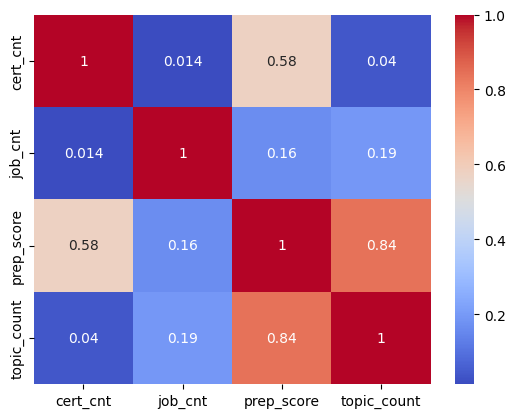

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_train[['cert_cnt','job_cnt','prep_score','topic_count']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


## 최적 피쳐 도출 

In [167]:
from catboost import (
    CatBoostClassifier, 
    Pool,
    EFeaturesSelectionAlgorithm,
    EShapCalcType
)

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score

# =========================
# 0) 컬럼 정리
# =========================
df_train.columns = df_train.columns.str.strip()
df_test.columns  = df_test.columns.str.strip()

# =========================
# 1) 기본 피처 정의
# =========================
BASE_FEATURES = [
    "completed_semester","inflow_route","major1_1","time_band",
    "project_type","cert_cnt","time_risk","job_cnt", "topic_count",
    "re_registration","hope_for_group","job","class_cnt",
    "time_input","prev_class_cnt","has_previous",
    "incumbents_company_level",
    'prep_score', 'class_ratio', 
    'sqld_cert', 'bigdata_cert', 'else_cert', 'cert_weighted',
    'offline',
    'var1', 'var2', 'var3', 'var4', 'var5',
    'prep_score_bin', 'cert_cnt_bin'
]

TARGET = "completed"

# =========================
# 2) 결측 보정
# =========================
def ensure_features(df, features):
    df = df.copy()
    for c in features:
        if c not in df.columns:
            df[c] = "missing" if df[c].dtype=="object" else 0
    return df

df_train = ensure_features(df_train, BASE_FEATURES+[TARGET])
df_test  = ensure_features(df_test, BASE_FEATURES)

# =========================
# 3) 데이터 준비
# =========================
X_all = df_train[BASE_FEATURES].copy()
y_all = df_train[TARGET].copy()
X_test_all = df_test[BASE_FEATURES].copy()

# 문자열 컬럼 자동 감지
for col in X_all.select_dtypes(include="object").columns:
    X_all[col] = X_all[col].astype(str)
    X_test_all[col] = X_test_all[col].astype(str)

# =========================
# 4) FS용 split (누수 방지)
# =========================
X_fs, _, y_fs, _ = train_test_split(
    X_all, y_all,
    test_size=0.3,
    stratify=y_all,
    random_state=42
)

base_cat = X_fs.select_dtypes(include="object").columns.tolist()

# =========================
# 5) k 탐색
# =========================
k_range = range(5, min(len(BASE_FEATURES),15))

best_global_f1 = 0
best_k = None
best_selected = None

for k in k_range:
    print(f"\n========== k={k} ==========")

    # -------- FS --------
    fs_model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.03,
        l2_leaf_reg=10,
        min_data_in_leaf=20,
        auto_class_weights="Balanced",
        loss_function="Logloss",
        early_stopping_rounds=100,
        random_seed=42,
        verbose=0
    )


    fs_pool = Pool(X_fs, y_fs, cat_features=base_cat)

    fs_result = fs_model.select_features(
        fs_pool,
        features_for_select=list(range(X_fs.shape[1])),
        num_features_to_select=k,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False
    )

    selected = [BASE_FEATURES[i] for i in fs_result["selected_features"]]
    print("Selected:", selected)

    # -------- 데이터 반영 --------
    X = X_all[selected].copy()
    y = y_all.copy()

    cat_features = X.select_dtypes(include="object").columns.tolist()

    # -------- CV --------
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    oof_pred = np.zeros(len(X))

    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.03,
        l2_leaf_reg=10,
        min_data_in_leaf=20,
        auto_class_weights="Balanced",
        loss_function="Logloss",
        early_stopping_rounds=100,
        random_seed=42,
        verbose=0
    )

    for tr, va in skf.split(X, y):
        tr_pool = Pool(X.iloc[tr], y.iloc[tr], cat_features=cat_features)
        va_pool = Pool(X.iloc[va], y.iloc[va], cat_features=cat_features)

        model.fit(tr_pool, eval_set=va_pool, use_best_model=True)
        oof_pred[va] = model.predict_proba(va_pool)[:,1]

    # -------- F1 --------
    best_f1 = 0
    for t in np.arange(0.1,0.9,0.02):
        f1 = f1_score(y,(oof_pred>=t).astype(int))
        best_f1 = max(best_f1,f1)

    print(f"k={k} → F1={best_f1:.5f}")

    if best_f1 > best_global_f1:
        best_global_f1 = best_f1
        best_k = k
        best_selected = selected

print("\n====== RESULT ======")
print("BEST k:", best_k)
print("BEST F1:", best_global_f1)
print("BEST FEATURES:", best_selected)



========== k=5 ==========
Step #1 out of 1
Feature #20 eliminated
Feature #30 eliminated
Feature #15 eliminated
Feature #9 eliminated
Feature #5 eliminated
Feature #29 eliminated
Feature #14 eliminated
Feature #19 eliminated
Feature #8 eliminated
Feature #4 eliminated
Feature #21 eliminated
Feature #17 eliminated
Feature #18 eliminated
Feature #23 eliminated
Feature #3 eliminated
Feature #7 eliminated
Feature #22 eliminated
Feature #13 eliminated
Feature #12 eliminated
Feature #26 eliminated
Feature #24 eliminated
Feature #6 eliminated
Feature #16 eliminated
Feature #11 eliminated
Feature #25 eliminated
Feature #1 eliminated
Selected: ['completed_semester', 'major1_1', 'hope_for_group', 'var4', 'var5']
k=5 → F1=0.46496

========== k=6 ==========
Step #1 out of 1
Feature #20 eliminated
Feature #30 eliminated
Feature #15 eliminated
Feature #9 eliminated
Feature #5 eliminated
Feature #29 eliminated
Feature #14 eliminated
Feature #19 eliminated
Feature #8 eliminated
Feature #4 eliminated


0.419일떄
'completed_semester', 'inflow_route', 'major1_1', 'cert_cnt', 'time_risk', 'topic_count', 'job_cnt', 'hope_for_group', 'job', 'prep_score'

In [ ]:
# =========================
# 1) 최종 피처 적용
# =========================
FINAL_FEATURES = best_selected

X = df_train[FINAL_FEATURES].copy()
y = df_train["completed"].copy()
X_test = df_test[FINAL_FEATURES].copy()

# categorical 자동 처리
cat_features = X.select_dtypes(include="object").columns.tolist()

for c in cat_features:
    X[c] = X[c].astype(str)
    X_test[c] = X_test[c].astype(str)

# =========================
# 2) CV 설정
# =========================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

oof_pred = np.zeros(len(X))
test_pred = np.zeros(len(X_test))

# =========================
# 3) 최종 CatBoost 모델
# =========================

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=2,
    l2_leaf_reg= 10,
    min_data_in_leaf=20,
    auto_class_weights="Balanced",
    loss_function="Logloss",
    eval_metric="AUC",
    custom_metric=["F1","AUC"],
    random_seed=42,
    early_stopping_rounds=100,
    verbose=200
)

# =========================
# 4) CV 학습
# =========================
for fold,(tr,va) in enumerate(skf.split(X,y),1):
    print(f"\n===== Fold {fold} =====")

    tr_pool = Pool(X.iloc[tr],y.iloc[tr],cat_features=cat_features)
    va_pool = Pool(X.iloc[va],y.iloc[va],cat_features=cat_features)
    te_pool = Pool(X_test,cat_features=cat_features)

    model.fit(tr_pool,eval_set=va_pool,use_best_model=True)

    oof_pred[va] = model.predict_proba(va_pool)[:,1]
    test_pred += model.predict_proba(te_pool)[:,1]/skf.n_splits

# =========================
# 5) Threshold 최적화
# =========================
best_thr,best_f1 = 0,0

for t in np.arange(0.05,0.95,0.01):
    f1 = f1_score(y,(oof_pred>=t).astype(int))
    if f1>best_f1:
        best_f1,best_thr = f1,t

print("Best threshold:",best_thr,"F1:",best_f1)

pred_test = (test_pred>=best_thr).astype(int)


===== Fold 1 =====
0:	test: 0.5375238	best: 0.5375238 (0)	total: 2.21ms	remaining: 2.21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6107809524
bestIteration = 28

Shrink model to first 29 iterations.

===== Fold 2 =====
0:	test: 0.5370270	best: 0.5370270 (0)	total: 765us	remaining: 765ms
200:	test: 0.5821622	best: 0.5880695 (134)	total: 146ms	remaining: 578ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5880694981
bestIteration = 134

Shrink model to first 135 iterations.

===== Fold 3 =====
0:	test: 0.5705792	best: 0.5705792 (0)	total: 924us	remaining: 923ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6838223938
bestIteration = 50

Shrink model to first 51 iterations.
Best threshold: 0.4800000000000001 F1: 0.4882108183079057


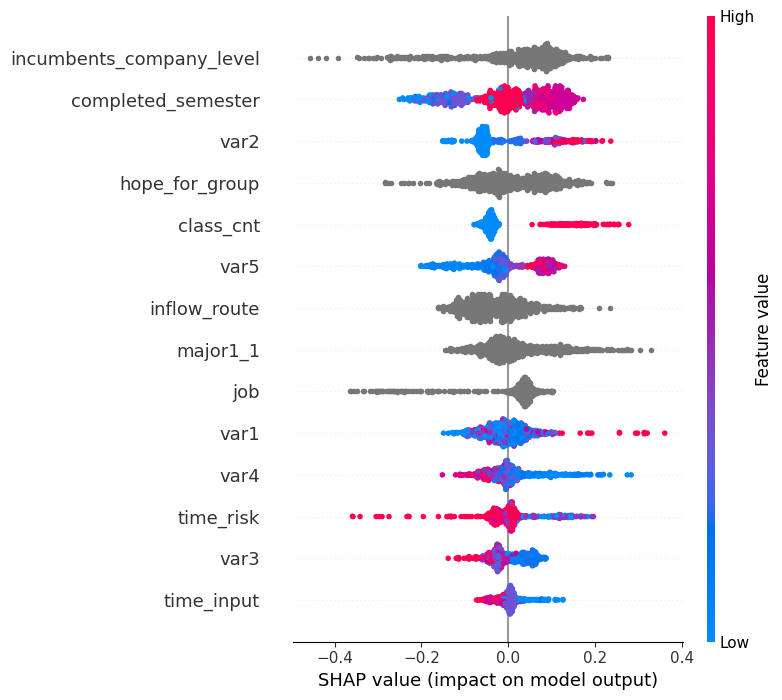

In [168]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)


In [169]:
from sklearn.metrics import classification_report

y_pred = (oof_pred >= best_thr).astype(int)

print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.52      0.62       525
           1       0.37      0.66      0.47       223

    accuracy                           0.56       748
   macro avg       0.58      0.59      0.55       748
weighted avg       0.66      0.56      0.58       748



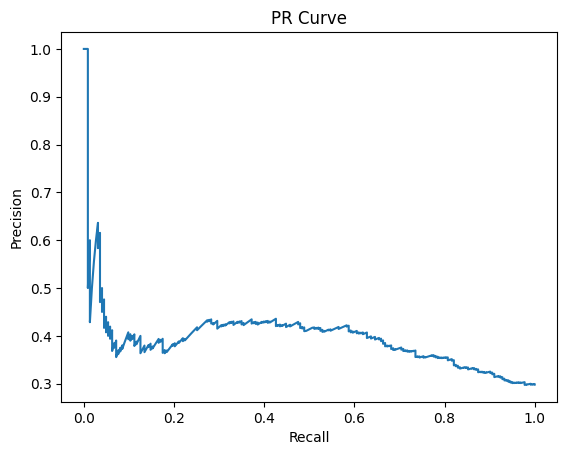

In [155]:
from sklearn.metrics import precision_recall_curve

p,r,_ = precision_recall_curve(y, oof_pred)

plt.plot(r,p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.show()


In [156]:
y.mean()


np.float64(0.29812834224598933)

In [ ]:
#calibration plot

In [127]:
# =========================
# 9) 제출 파일 생성
# =========================
sample = pd.read_csv("OriginalData/sample_submission.csv")

sub = sample.copy()
sub["completed"] = pred_test
sub.to_csv("Submit/catboost0209.csv",index=False)

print("Saved: catboost0209.csv")

Saved: catboost0209.csv


## logistic

In [130]:
import numpy as np

def clean_df(df):
    df = df.copy()

    # inf → nan
    df = df.replace([np.inf, -np.inf], np.nan)

    # 수치형
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # 범주형
    cat_cols = df.select_dtypes(include="object").columns
    df[cat_cols] = df[cat_cols].fillna("missing")

    return df


In [146]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.base import clone

# =========================
# 1️⃣ 데이터 준비
# =========================

X = df_train[best_selected].copy()
y = df_train[TARGET].copy()
X_test = df_test[best_selected].copy()

# =========================
# 2️⃣ 컬럼 구분
# =========================

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# =========================
# 3️⃣ 전처리 파이프라인
# =========================

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),

        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_cols)
    ]
)

log_model = Pipeline([
    ("prep", preprocess),
    ("lr", LogisticRegression(max_iter=3000))
])

# =========================
# 4️⃣ CV OOF 예측
# =========================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lr = np.zeros(len(X))
test_lr = np.zeros(len(X_test))

for tr, va in skf.split(X, y):

    model = clone(log_model)

    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    model.fit(X_tr, y_tr)

    oof_lr[va] = model.predict_proba(X_va)[:,1]
    test_lr += model.predict_proba(X_test)[:,1] / skf.n_splits

# =========================
# 5️⃣ 최적 threshold 탐색
# =========================

p,r,thr = precision_recall_curve(y,oof_lr)
f1_scores = 2*p*r/(p+r+1e-9)

mask = thr >= 0.3

best_idx = np.argmax(f1_scores[:-1][mask])
best_thr = thr[mask][best_idx]
best_f1 = f1_scores[:-1][mask][best_idx]

print("LR Best F1:", round(best_f1,4))
print("Best threshold:", round(best_thr,4))
pred_test_lr = (test_lr >= best_thr).astype(int)


LR Best F1: 0.4152
Best threshold: 0.3019


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/miniconda3/lib/python3.13/site-packag

In [147]:
from sklearn.metrics import classification_report

y_pred_lr = (oof_lr>=best_thr).astype(int)

print(classification_report(y,y_pred_lr))


              precision    recall  f1-score   support

           0       0.74      0.63      0.68       525
           1       0.36      0.49      0.42       223

    accuracy                           0.59       748
   macro avg       0.55      0.56      0.55       748
weighted avg       0.63      0.59      0.60       748



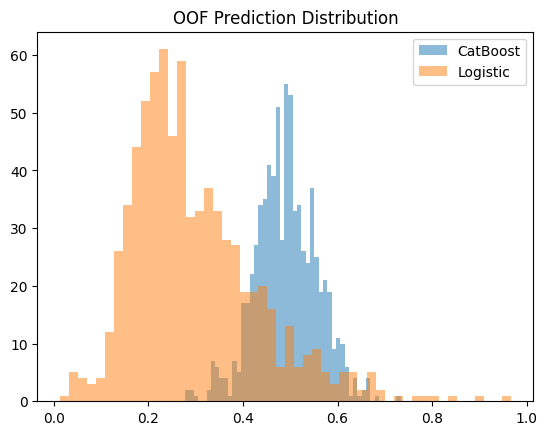

In [157]:
import matplotlib.pyplot as plt

plt.hist(oof_pred, bins=50, alpha=0.5, label="CatBoost")
plt.hist(oof_lr, bins=50, alpha=0.5, label="Logistic")

plt.legend()
plt.title("OOF Prediction Distribution")
plt.show()


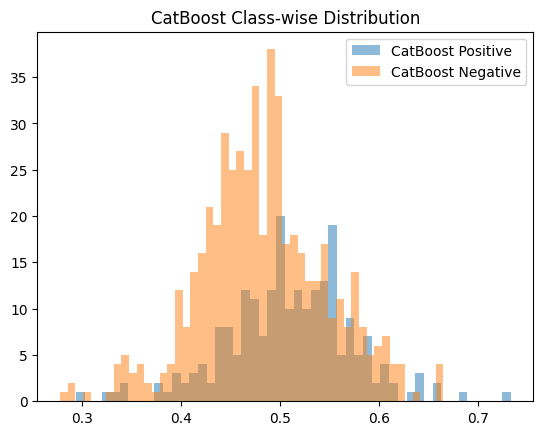

In [158]:
# 클래스별 분포
plt.hist(oof_pred[y==1], bins=50, alpha=0.5, label="CatBoost Positive")
plt.hist(oof_pred[y==0], bins=50, alpha=0.5, label="CatBoost Negative")

plt.legend()
plt.title("CatBoost Class-wise Distribution")
plt.show()


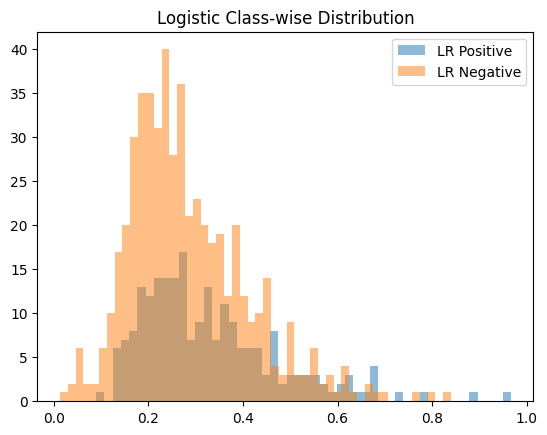

In [150]:
plt.hist(oof_lr[y==1], bins=50, alpha=0.5, label="LR Positive")
plt.hist(oof_lr[y==0], bins=50, alpha=0.5, label="LR Negative")

plt.legend()
plt.title("Logistic Class-wise Distribution")
plt.show()


In [159]:
oof_pred   # CatBoost OOF
oof_lr     # Logistic OOF
test_pred  # CatBoost test
test_lr    # Logistic test
# =========================
blend_oof = 0.8*oof_pred + 0.2*oof_lr
blend_test = 0.8*test_pred + 0.2*test_lr
# =========================
best_f1 = 0
best_w = 0

for w in np.arange(0,1.01,0.05):
    blend = w*oof_pred + (1-w)*oof_lr
    
    for t in np.arange(0.05,0.95,0.01):
        f1 = f1_score(y,(blend>=t).astype(int))
        
        if f1>best_f1:
            best_f1 = f1
            best_w = w
            best_t = t

print("Best weight (CatBoost):",best_w)
print("Best threshold:",best_t)
print("Best F1:",best_f1)



Best weight (CatBoost): 0.9500000000000001
Best threshold: 0.45000000000000007
Best F1: 0.4897959183673469


In [160]:
blend_test = best_w*test_pred + (1-best_w)*test_lr

final_pred = (blend_test>=best_t).astype(int)


In [163]:
sub = pd.read_csv("OriginalData/sample_submission.csv")
sub["completed"] = final_pred
sub.to_csv(f"Submit/blend_submission_0209_{best_f1:.4f}.csv",index=False)

print(f"Saved: blend_submission_0209_{best_f1:.4f}.csv")


Saved: blend_submission_0209_0.4898.csv
